In [1]:
import os
import math
import numpy as np
from fractions import Fraction
from collections import defaultdict
from typing import Dict, List, Tuple, Set
from tqdm import tqdm
import multiprocessing as mp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FixedLocator, FuncFormatter
from haversine import haversine, Unit
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.basemap import Basemap

In [2]:
# Astronomy-related constants

TE = 24 * 3600  # One Earth sidereal day in seconds

RE = 6371e3  # Mean radius of Earth in meters

u = 3.986e14  # Standard gravitational parameter (μ = GM) in m^3/s^2

K = RE / pow(u, 1/3) * pow(2 * np.pi, 2/3)  

eps = 25 * np.pi / 180  # Maximum elevation angle for ground access, in radians (25°)

In [3]:
def satellite_period(h):
    """
    Compute orbital period based on altitude h (in meters).
    
    Args:
        h (float): Satellite altitude in meters
    
    Returns:
        float: Orbital period in seconds
    """
    a = RE + h
    T = float(2 * np.pi * pow(a**3 / u, 0.5))  # Kepler's Third Law
    return T


def approximate_ratio(a, b, precision=1e-3):
    """
    Approximate the simplest integer ratio between two values.
    
    Args:
        a, b (float): Input values
        precision (float): Allowed approximation error
    
    Returns:
        (int, int): Simplified numerator and denominator
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero")
    ratio = Fraction(a, b).limit_denominator(int(1 / precision))
    return ratio.numerator, ratio.denominator
def coverage_eta(T):
    """
    Compute half-angle ground coverage (in radians) from orbital period.
    
    Args:
        T (float): Orbital period in seconds
    
    Returns:
        float: Coverage angle in radians
    """
    eta = math.acos(K * math.cos(eps) / pow(T, 2 / 3)) - eps
    return eta
def alpha_gamma_to_lambda_phi(alpha, gamma, alpha0, inc):
    """
    Convert satellite-centric coordinates to Earth-centric lon/lat.
    
    Args:
        alpha (float): In-track satellite angle (rad)
        gamma (float): Along-track angle (rad)
        alpha0 (float): Reference phase angle (unused here)
        inc (float): Orbital inclination (rad)
    
    Returns:
        (float, float): (longitude, latitude) in radians
    """
    phi = math.asin(math.sin(inc) * math.sin(gamma))
    temp = math.atan2(math.cos(inc) * math.sin(gamma), math.cos(gamma))
    lamb = (temp + alpha) % (2 * math.pi)
    if lamb > math.pi:
        lamb -= 2 * math.pi
    return lamb, phi
def get_allfile(path):
    """
    List all non-checkpoint files under a directory.
    
    Args:
        path (str): Directory path
    
    Returns:
        list[str]: List of full file paths
    """
    all_file = []
    for f in os.listdir(path):
        f_name = os.path.join(path, f)
        if "ipynb_checkpoints" not in f_name:
            all_file.append(f_name)
    return all_file
def calculate_cell_area():
    """
    Calculate the surface area of each cell on the Earth based on latitude.

    Returns:
        List[float]: Area (in m²) of each cell.
    """
    S_set = []
    for idx, cell in enumerate(cell_list):
        lat_deg = cell[0]
        lat_rad = np.radians(lat_deg)           # Convert latitude to radians
        cell_height = RE * np.radians(cell_size)  # Vertical length of the cell (in meters)

        # Compute the arc length (horizontal width) at top and bottom of the cell
        L1 = RE * np.sin(np.pi / 2 - abs(lat_rad)) * np.radians(cell_size)
        tmp = abs(lat_rad - np.radians(cell_size))
        L2 = RE * np.sin(np.pi / 2 - min(tmp, np.pi / 2)) * np.radians(cell_size)

        # Adjust height at the South Pole edge
        if tmp > np.pi / 2:
            cell_height = RE * abs(lat_rad + np.pi / 2)

        # Trapezoid area: average width × height
        area = 0.5 * cell_height * (L1 + L2)
        S_set.append(area)

    return S_set

def cal_supply_all_cell(sat_pos):
    """
    Calculate supply distribution from one satellite position
    """
    l_sat, p_sat = sat_pos
    r_set = []

    for idx, cell in enumerate(cell_list):
        l_cell = np.radians(cell[1])
        p_cell = np.radians(cell[0])
        if is_cover(l_sat, p_sat, l_cell, p_cell, eta):
            S = S_set[idx]
            r_set.append([idx, S, 0])
        else:
            r_set.append([idx, 0, 0])

    S_sum = np.sum([item[1] for item in r_set])
    if S_sum != 0:
        r_set = [item[1] / S_sum * user_per_sat for item in r_set]
    else:
        r_set = [0] * len(cell_list)

    return [r_set, sat_pos]
    
def is_cover(l_sat, p_sat, l_cell, p_cell, eta):
    """
    Check if a satellite covers a ground cell
    """
    double_eta = 2 * eta

    if (p_sat - double_eta) < -np.pi / 2 or (p_sat + double_eta) > np.pi / 2 or \
       (l_sat - double_eta) < -np.pi or (l_sat + double_eta) > np.pi:
        d = haversine((np.degrees(p_sat), np.degrees(l_sat)),
                      (np.degrees(p_cell), np.degrees(l_cell)),
                      unit=Unit.METERS)
        return d <= eta * RE
    else:
        if (p_sat - double_eta) <= p_cell <= (p_sat + double_eta) and \
           (l_sat - double_eta) <= l_cell <= (l_sat + double_eta):
            d = haversine((np.degrees(p_sat), np.degrees(l_sat)),
                          (np.degrees(p_cell), np.degrees(l_cell)),
                          unit=Unit.METERS)
            return d <= eta * RE

    return False


In [4]:
# === Define Custom Colormap for Visualization ===

# Hex color string from light to dark
color_str = '#ffffff,#b4d9cc,#89c0b6,#63a6a0,#448c8a,#287274,#0d585f'
cmap_colors = color_str.split(',')

# Convert hex color strings to RGB tuples
color_list = [plt.cm.colors.hex2color(color) for color in cmap_colors]

data_max = 10  # Maximum value for color scaling

# Generate evenly spaced boundaries based on number of colors
color_bounds = np.linspace(0, data_max, len(cmap_colors))

# Normalize boundaries to [0, 1]
normalized_bounds = color_bounds / color_bounds[-1]

# Create a list of (position, color) for segmented colormap
colors = list(zip(normalized_bounds, color_list))

# Build a custom colormap and normalization object
cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)
norm = Normalize(vmin=0, vmax=data_max)


In [5]:
data_file="data/TinyLEO_for_Latin_America.npy"
supply_data=np.load(data_file,allow_pickle=True)
h=573
T=satellite_period(h*1e3)
p,q=approximate_ratio(int(T), TE,precision=1e-3)
eta=coverage_eta(T)
step=2*eta

In [6]:
cell_list=np.load("data/plot_cell_one_degree.npy",allow_pickle=True)
cell_size=1
user_per_sat = 960
# Compute cell areas
S_set = calculate_cell_area()

In [8]:
# Aggregate satellite coverage at a specific time slot
plt_data = []
sat_map = []
time_shift = 128  # Time slot index

for param, random_numbers, sat_location, sat_num in tqdm(supply_data):
    sat_pair = sat_location[time_shift]
    key = f"{sat_pair[0]}_{sat_pair[1]}"
    
    # Accumulate weighted supply data
    # current_cover = np.array(full_cover_sat[key]) * sat_num
    current_cover=np.array(cal_supply_all_cell(sat_pair)[0])
    if len(plt_data) == 0:
        plt_data = current_cover
    else:
        plt_data += current_cover

    sat_map.append(sat_pair)

# Check data range for visualization
print(np.min(plt_data), np.max(plt_data))

# Normalize and create color map for plotting
norm = Normalize(vmin=0, vmax=np.max(plt_data))
colormap = plt.cm.Blues
sm = ScalarMappable(norm=norm, cmap=colormap)


100%|██████████| 1065/1065 [02:57<00:00,  6.00it/s]

0.0 66.74686108121547


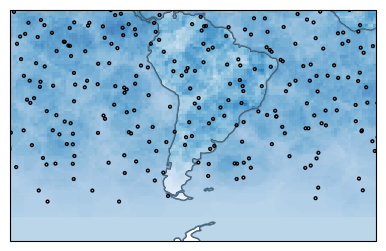

In [9]:
# Plot satellite supply heatmap over South America
fig, ax = plt.subplots(figsize=(5, 3), subplot_kw={'projection': ccrs.PlateCarree()})

# Add base map
# m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')
ax.coastlines()
ax.set_global()

# Add ocean background
ocean_feature = cfeature.NaturalEarthFeature(
    'physical', 'ocean', '110m',
    edgecolor='face',
    facecolor='#7BAED5',
    alpha=0.5
)
ax.add_feature(ocean_feature)


# Draw rectangular cells colored by supply
for cid, value in enumerate(plt_data):
    lat, lon = cell_list[cid]
    color = sm.to_rgba(value)
    rect = matplotlib.patches.Rectangle((lon, lat - cell_size), cell_size, cell_size, color=color, alpha=0.9)
    ax.add_patch(rect)

# Draw satellite locations
for sat in sat_map:
    lon_deg, lat_deg = np.degrees(sat[0]), np.degrees(sat[1])
    plt.scatter(lon_deg, lat_deg, s=4, c='none', marker='o', edgecolors="black", zorder=3)

# Set view window to South America
plt.xlim(-130, 0)
plt.ylim(-70, 12)

# Save figure
plt.savefig("figure14c.pdf", bbox_inches="tight")
plt.savefig("figure14c.png", bbox_inches="tight")